In [1]:
import os
import sys
import gym
import random
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import namedtuple, deque

## utils

In [2]:
Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))


class Memory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))

    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        return batch

    def __len__(self):
        return len(self.memory)


In [3]:
def get_action(state, online_net, epsilon, env):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        return online_net.get_action(state)

def update_target_model(online_net, target_net):
    target_net.load_state_dict(online_net.state_dict())

## DQN

In [4]:
class QNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(QNet, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        qvalue = self.fc2(x)
        return qvalue

    @classmethod
    def train_model(cls, online_net, target_net, optimizer, batch):
        states = torch.stack(batch.state)
        next_states = torch.stack(batch.next_state)
        actions = torch.Tensor(batch.action).float()
        rewards = torch.Tensor(batch.reward)
        masks = torch.Tensor(batch.mask)

        pred = online_net(states).squeeze(1)
        next_pred = target_net(next_states).squeeze(1)

        pred = torch.sum(pred.mul(actions), dim=1)

        target = rewards + masks * gamma * next_pred.max(1)[0]

        loss = F.mse_loss(pred, target.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss

    def get_action(self, input):
        qvalue = self.forward(input)
        _, action = torch.max(qvalue, 1)
        return action.numpy()[0]

###  hyper parameters

In [12]:
gamma = 0.99
batch_size = 64
lr = 0.0005
log_interval = 10
update_target = 20
replay_memory_capacity = 1000
count_epsds = 500
epsilon = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


##### train 

In [13]:
env_name = 'LunarLander-v2'


env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)

num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n

In [15]:
online_net = QNet(num_inputs, num_actions)
target_net = QNet(num_inputs, num_actions)
update_target_model(online_net, target_net)
optimizer = optim.Adam(online_net.parameters(), lr=lr)

online_net.to(device)
target_net.to(device)
online_net.train()
target_net.train()
memory = Memory(replay_memory_capacity)

steps = 0
loss = 0
nbr_actions_list, score_list, loss_list = [],[],[]

for e in range(count_epsds):
    
    done = False
    score = 0
    state = env.reset()
    state = torch.Tensor(state).to(device)
    state = state.unsqueeze(0)
    nbr_actions = 0
    avg_loss = 0 
    while not done:
        
        
        
        steps += 1


        action = get_action(state, online_net, epsilon, env)
        next_state, reward, done, _ = env.step(action)
        nbr_actions += 1
        next_state = torch.Tensor(next_state)
        next_state = next_state.unsqueeze(0)

        mask = 0 if done else 1
        reward = reward if not done or score == 499 else -1
        action_one_hot = np.zeros(4)
        action_one_hot[action] = 1
        memory.push(state, next_state, action_one_hot, reward, mask)

        score += reward
        state = next_state
        
        if ( e % 100 ):
            env.render(0.0001)
        
        if steps > replay_memory_capacity:

            epsilon -= 0.00005
            epsilon = max(epsilon, 0.01)
    
            batch = memory.sample(batch_size)
            loss = QNet.train_model(online_net, target_net, optimizer, batch)

            if steps % update_target == 0:
                update_target_model(online_net, target_net)

            
            avg_loss += loss
            
    score_list.append(score)
    
    
    if e % log_interval == 0:
    
        print('episode {}| score: {} | epsilon: {:.2f}'.format(
            e, nbr_actions, epsilon))
        

episode 0| score: 102 | epsilon: 1.00
episode 10| score: 101 | epsilon: 1.00
episode 20| score: 86 | epsilon: 0.95
episode 30| score: 111 | epsilon: 0.90
episode 40| score: 67 | epsilon: 0.85
episode 50| score: 101 | epsilon: 0.80
episode 60| score: 114 | epsilon: 0.74
episode 70| score: 130 | epsilon: 0.69
episode 80| score: 86 | epsilon: 0.62
episode 90| score: 252 | epsilon: 0.54
episode 100| score: 201 | epsilon: 0.43
episode 110| score: 373 | epsilon: 0.31
episode 120| score: 171 | epsilon: 0.11
episode 130| score: 190 | epsilon: 0.01
episode 140| score: 654 | epsilon: 0.01
episode 150| score: 189 | epsilon: 0.01
episode 160| score: 467 | epsilon: 0.01
episode 170| score: 238 | epsilon: 0.01
episode 180| score: 100 | epsilon: 0.01
episode 190| score: 483 | epsilon: 0.01
episode 200| score: 372 | epsilon: 0.01
episode 210| score: 370 | epsilon: 0.01
episode 220| score: 185 | epsilon: 0.01
episode 230| score: 1000 | epsilon: 0.01
episode 240| score: 1000 | epsilon: 0.01
episode 250|

In [16]:
env.close()

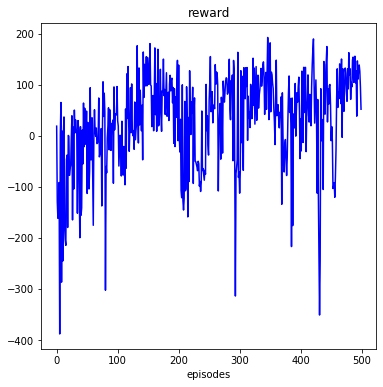

In [21]:
plt.figure(figsize=(6,6))
    


plt.plot( np.arange(count_epsds), score_list, "b")
plt.xlabel('episodes')
plt.title("reward")



plt.show()